# installations

In [1]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.8 MB/s eta 0:00:00


# uploading data

In [15]:
import pandas as pd

# Use raw string (r'...') to avoid issues with backslashes in Windows paths
file_path = r'FilteredData100.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Preview the first few rows
print(df.head())


   Y1  Y2    Y    Domain                     area  \
0   0  12   12       CS    Symbolic computation     
1   5   2   74  Medical     Alzheimer's Disease     
2   4   7   68    Civil          Green Building     
3   1  10   26      ECE          Electric motor     
4   5  43  115  Medical     Parkinson's Disease     

                                            keywords  \
0   (2+1)-dimensional non-linear optical waves; e...   
1   Aging; Tau; Amyloid; PET; Alzheimer's disease...   
2   LED lighting system; PV system; Distributed l...   
3   NdFeB magnets; Electric motor; Electric vehic...   
4   Parkinson's disease; dyskinesia; adenosine A(...   

                                            Abstract  
0  (2 + 1)-dimensional non-linear optical waves t...  
1  (beta-amyloid (A beta) and tau pathology becom...  
2  (D)ecreasing of energy consumption and environ...  
3  (Hybrid) electric vehicles are assumed to play...  
4  (L)-3,4-Dihydroxyphenylalanine ((L)-DOPA) rema...  


In [18]:
num_unique_areas   = df['area'].nunique()
num_unique_domains = df['Domain'].nunique()

print(f"Number of unique areas:   {num_unique_areas}")
print(f"Number of unique domains: {num_unique_domains}")

Number of unique areas:   130
Number of unique domains: 7


# LDA with Random Forest

In [1]:
%pip install --upgrade gensim nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [11]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score,classification_report

nltk.download('stopwords')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display
# enable inline display in Colab
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Predict Abstracts Based On Area

In [8]:

#  Settings
SEED = 42
NUM_TOPICS_AREA = 130

# Stopwords & preprocessing
nltk.download('stopwords')
stop_words_area = set(stopwords.words('english'))

def preprocess_area(doc):
    return [
        w for w in simple_preprocess(str(doc), deacc=True)
        if w not in stop_words_area
    ]

# 70/15/15 split stratified on 'area'
train_df_area, temp_df_area = train_test_split(
    df,
    test_size=0.30,
    stratify=df["area"],
    random_state=SEED
)
val_df_area, test_df_area = train_test_split(
    temp_df_area,
    test_size=0.50,
    stratify=temp_df_area["area"],
    random_state=SEED
)

# Preprocess abstracts
processed_train_area = [preprocess_area(txt) for txt in train_df_area['Abstract']]
processed_val_area   = [preprocess_area(txt) for txt in val_df_area['Abstract']]
processed_test_area  = [preprocess_area(txt) for txt in test_df_area['Abstract']]

# Build Dictionary & Corpus on TRAIN only
dictionary_area   = Dictionary(processed_train_area)
corpus_train_area = [dictionary_area.doc2bow(text) for text in processed_train_area]

# Train LDA
lda_area = LdaModel(
    corpus=corpus_train_area,
    id2word=dictionary_area,
    num_topics=NUM_TOPICS_AREA,
    random_state=SEED,
    passes=10
)

# Helper to get dense topic vectors
def lda_vector_area(bow):
    return [prob for _, prob in lda_area.get_document_topics(bow, minimum_probability=0.0)]

# Vectorize each split
X_train_area = [lda_vector_area(dictionary_area.doc2bow(text)) for text in processed_train_area]
X_val_area   = [lda_vector_area(dictionary_area.doc2bow(text)) for text in processed_val_area]
X_test_area  = [lda_vector_area(dictionary_area.doc2bow(text)) for text in processed_test_area]

# Encode 'area' labels
le_area        = LabelEncoder().fit(df['area'])
y_train_area   = le_area.transform(train_df_area['area'])
y_val_area     = le_area.transform(val_df_area['area'])
y_test_area    = le_area.transform(test_df_area['area'])

# Train Random Forest
rf_area = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_area.fit(X_train_area, y_train_area)

# Evaluate on validation set
y_val_area_pred = rf_area.predict(X_val_area)
val_acc_area    = accuracy_score(y_val_area, y_val_area_pred)
val_prec_area   = precision_score(y_val_area, y_val_area_pred, average='weighted')
val_rec_area    = recall_score(y_val_area, y_val_area_pred, average='weighted')
val_f1_area     = f1_score(y_val_area, y_val_area_pred, average='weighted')

print("=== Validation Results (area) ===")
print(f"Accuracy:  {val_acc_area:.4f}")
print(f"Precision: {val_prec_area:.4f}")
print(f"Recall:    {val_rec_area:.4f}")
print(f"F1:        {val_f1_area:.4f}")
print(classification_report(y_val_area, y_val_area_pred, target_names=le_area.classes_))

# Evaluate on test set
y_test_area_pred = rf_area.predict(X_test_area)
test_acc_area    = accuracy_score(y_test_area, y_test_area_pred)
test_prec_area   = precision_score(y_test_area, y_test_area_pred, average='weighted')
test_rec_area    = recall_score(y_test_area, y_test_area_pred, average='weighted')
test_f1_area     = f1_score(y_test_area, y_test_area_pred, average='weighted')

print("=== Test Results (area) ===")
print(f"Accuracy:  {test_acc_area:.4f}")
print(f"Precision: {test_prec_area:.4f}")
print(f"Recall:    {test_rec_area:.4f}")
print(f"F1:        {test_f1_area:.4f}")
print(classification_report(y_test_area, y_test_area_pred, target_names=le_area.classes_))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Validation Results (area) ===
Accuracy:  0.3963
Precision: 0.3866
Recall:    0.3963
F1:        0.3772
                                    precision    recall  f1-score   support

                       Addiction         0.14      0.06      0.09        47
                Algorithm design         0.09      0.05      0.07        57
                       Allergies         0.37      0.26      0.31        53
             Alzheimer's Disease         0.49      0.62      0.54        55
            Ambient Intelligence         0.36      0.42      0.39        62
        Analog signal processing         0.45      0.62      0.52        61
          Ankylosing Spondylitis         0.28      0.33      0.30        48
 Antisocial personality disorder         0.43      0.65      0.52        55
                         Anxiety         0.07      0.03      0.04        39
                          Asthma         0.24      0.12      0.16        48
               Atopic Dermatitis         0.32      0.28  

## Accuracy Per Class

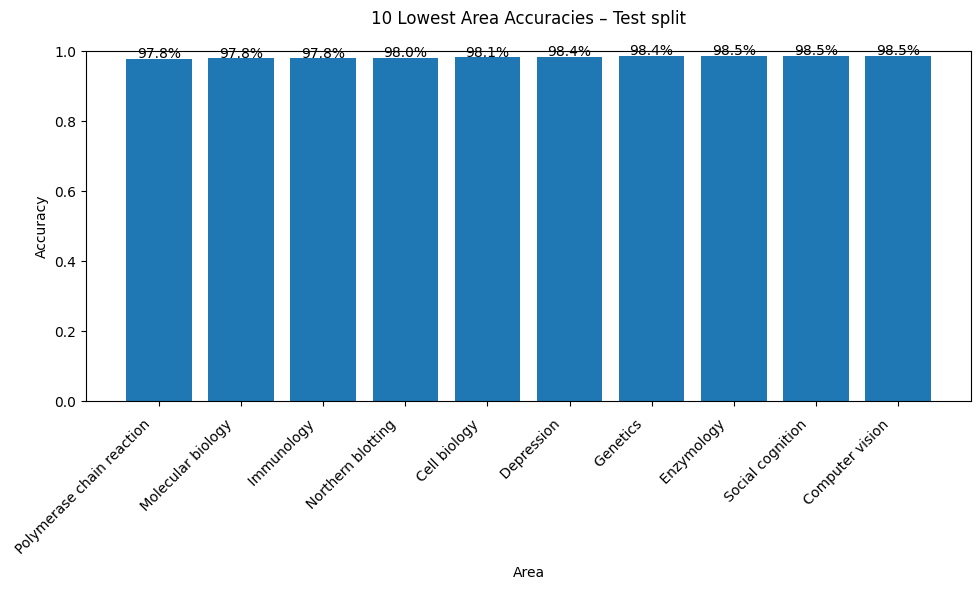

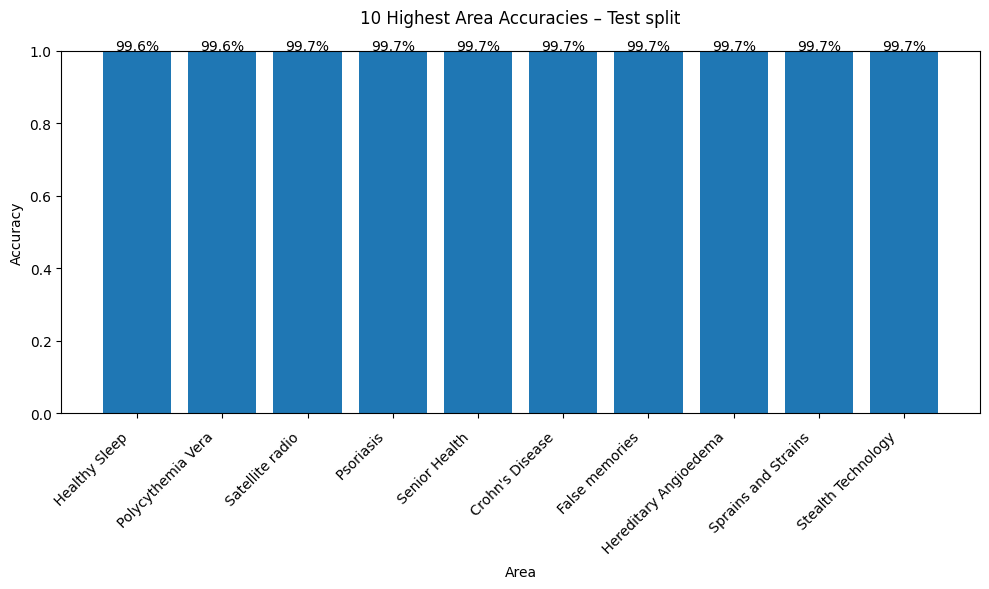

In [9]:

#  Confusion matrix over all 130 areas
cm = confusion_matrix(
    y_test_area,
    y_test_area_pred,
    labels=np.arange(len(le_area.classes_))
)
N = cm.sum()

# Compute each area’s accuracy = (TP + TN) / N
area_accuracies = []
for i in range(len(le_area.classes_)):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    tn = N - tp - fn - fp
    area_accuracies.append((tp + tn) / N)

# Pack into DataFrame and sort
acc_df = pd.DataFrame({
    'area':     le_area.classes_,
    'accuracy': area_accuracies
}).sort_values('accuracy', ascending=True)

lowest_df  = acc_df.head(10)   # 10 worst
highest_df = acc_df.tail(10)   # 10 best

# 10 Lowest Area Accuracies
plt.figure(figsize=(10, 6))
plt.bar(lowest_df['area'], lowest_df['accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Area')
plt.title('10 Lowest Area Accuracies – Test split', pad=20)
for i, acc in enumerate(lowest_df['accuracy']):
    plt.text(i, acc + 0.005, f"{acc:.1%}", ha='center')
plt.tight_layout()
plt.show()

# 10 Highest Area Accuracies
plt.figure(figsize=(10, 6))
plt.bar(highest_df['area'], highest_df['accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Area')
plt.title('10 Highest Area Accuracies – Test split', pad=20)
for i, acc in enumerate(highest_df['accuracy']):
    plt.text(i, acc + 0.005, f"{acc:.1%}", ha='center')
plt.tight_layout()
plt.show()


## per class recall

#### With 130 fine-grained areas—many of them rare—a high overall accuracy mostly reflects the huge number of true negatives (papers not in each area) and can mask the fact that your model never actually picks up certain categories. Recall (TP / [TP + FN]) zeroes in on how many of an area’s true abstracts you actually catch, so it’s the key metric to ensure even low-support topics aren’t being ignored.

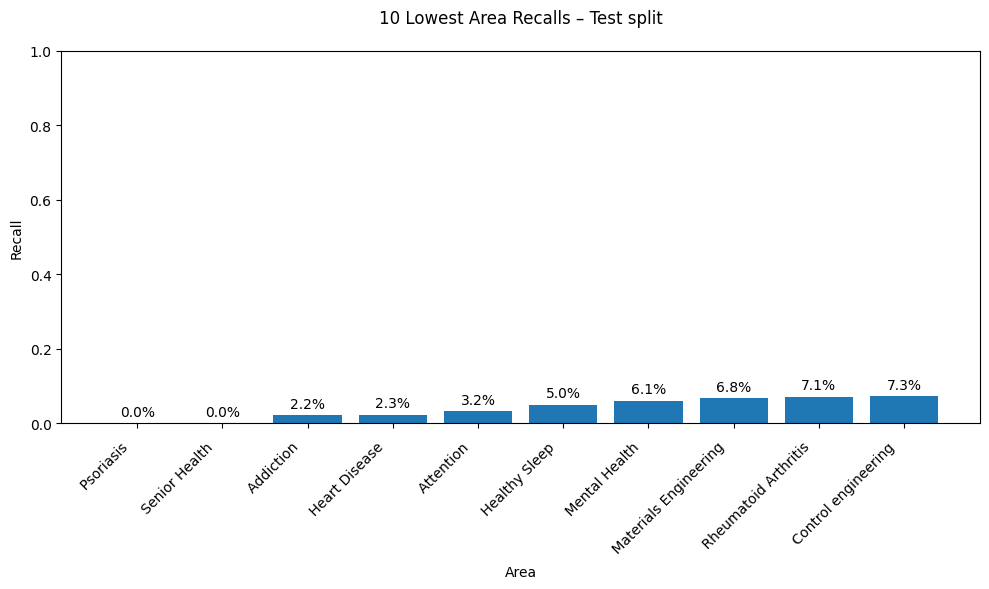

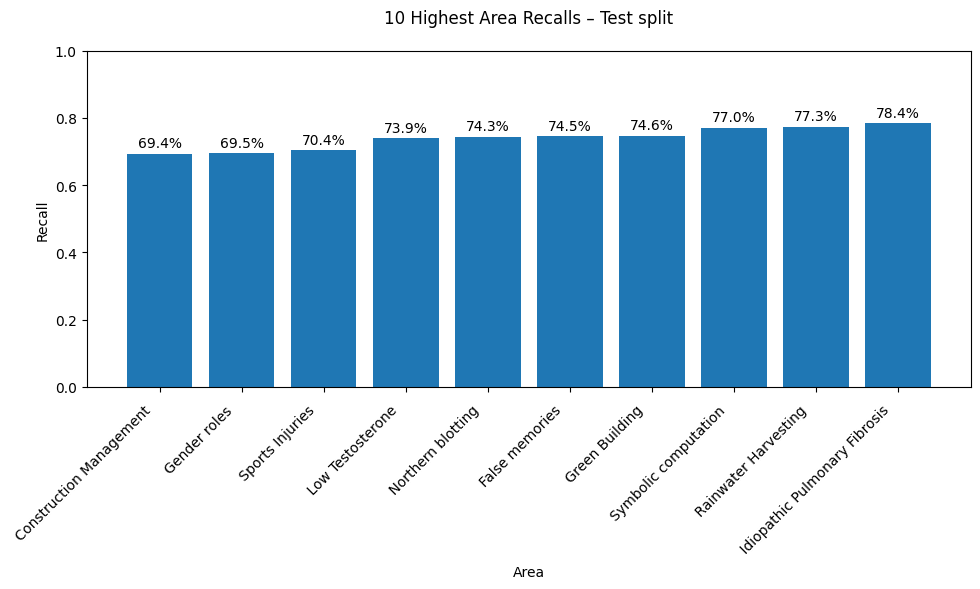

In [10]:

# Build confusion matrix over all 130 areas
cm = confusion_matrix(
    y_test_area,
    y_test_area_pred,
    labels=np.arange(len(le_area.classes_))
)

# Compute per-class recall = TP / (TP + FN)
recalls_area = []
for i in range(len(le_area.classes_)):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    recalls_area.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

# Pack into DataFrame & sort
df_rec_area = pd.DataFrame({
    'area':   le_area.classes_,
    'recall': recalls_area
}).sort_values('recall')

lowest_area_rec  = df_rec_area.head(10)
highest_area_rec = df_rec_area.tail(10)

# Plot 10 lowest recalls
plt.figure(figsize=(10, 6))
plt.bar(lowest_area_rec['area'], lowest_area_rec['recall'])
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.xlabel('Area')
plt.title('10 Lowest Area Recalls – Test split', pad=20)
for i, r in enumerate(lowest_area_rec['recall']):
    plt.text(i, r + 0.02, f"{r:.1%}", ha='center')
plt.tight_layout()
plt.show()

# Plot 10 highest recalls
plt.figure(figsize=(10, 6))
plt.bar(highest_area_rec['area'], highest_area_rec['recall'])
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.xlabel('Area')
plt.title('10 Highest Area Recalls – Test split', pad=20)
for i, r in enumerate(highest_area_rec['recall']):
    plt.text(i, r + 0.02, f"{r:.1%}", ha='center')
plt.tight_layout()
plt.show()


## LDA Visualizer for Area

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# enable the notebook renderer (only once per notebook)
pyLDAvis.enable_notebook()

# prepare the visualization data using the area‐specific objects
vis_area = pyLDAvis.gensim_models.prepare(
    lda_area,           #  LDA model for areas
    corpus_train_area,  #  area‐training corpus
    dictionary_area     #  area dictionary
)

# display it inline
vis_area

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
85    -0.233906 -0.112211       1        1  3.588782
75    -0.242781 -0.215795       2        1  3.103353
103   -0.257712  0.112429       3        1  3.097045
77    -0.225629  0.168046       4        1  2.985446
52    -0.228127 -0.202226       5        1  2.970466
...         ...       ...     ...      ...       ...
71     0.141247 -0.011786     130        1  0.186824
88     0.147564 -0.003525     131        1  0.169302
97     0.143419  0.004049     132        1  0.167391
125    0.140686  0.010038     133        1  0.165198
99     0.139087 -0.003509     134        1  0.160871

[134 rows x 5 columns], topic_info=              Term          Freq         Total  Category  logprob  loglift
116       patients  21487.000000  21487.000000   Default  30.0000  30.0000
776         system  12779.000000  12779.000000   Default  29.0000  29.0000
8            group   8047.000000   8047.000000   Default  28.0000  28.0000
565          model  11670.000000  11670.000000   Default  27.0000  27.0000
139      treatment   9967.000000   9967.000000   Default  26.0000  26.0000
...            ...           ...           ...       ...      ...      ...
11888        slope    214.759879    259.752809  Topic134  -3.4239   6.2421
8352         spent    159.381288    192.437726  Topic134  -3.7221   6.2439
5036   disturbance    178.052824    331.927579  Topic134  -3.6113   5.8095
9130         steel    182.462962    346.059511  Topic134  -3.5869   5.7923
1005          time     45.895024  10116.070368  Topic134  -4.9670   1.0368

[6967 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
12802     25  0.995620         aa
6270      49  0.995155         ab
12123      9  0.988322        abc
8639      10  0.003588  abdominal
8639      17  0.308587  abdominal
...      ...       ...        ...
12467     44  0.985061  zebrafish
8017      35  0.028879       zinc
8017      66  0.967458       zinc
9258      66  0.992116         zn
13379     44  0.981778        zno

[19154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[86, 76, 104, 78, 53, 61, 93, 92, 123, 125, 87, 57, 50, 52, 71, 134, 69, 19, 60, 106, 70, 80, 111, 26, 1, 108, 51, 58, 21, 132, 47, 101, 77, 90, 27, 37, 23, 6, 113, 120, 88, 45, 55, 66, 3, 24, 12, 28, 41, 56, 46, 4, 124, 48, 122, 119, 130, 103, 121, 29, 44, 102, 64, 54, 62, 11, 127, 42, 22, 17, 128, 129, 117, 18, 75, 13, 5, 73, 107, 96, 43, 59, 10, 32, 83, 94, 114, 7, 74, 8, 81, 49, 133, 15, 95, 39, 67, 20, 91, 25, 116, 82, 99, 30, 16, 40, 118, 33, 38, 34, 2, 79, 35, 109, 63, 131, 14, 105, 36, 112, 84, 115, 110, 31, 68, 65, 9, 97, 85, 72, 89, 98, 126, 100])

## Manual Inspection

In [13]:
# Build a results DataFrame for areas
results_area = test_df_area.copy()
results_area['true_area'] = le_area.inverse_transform(y_test_area)
results_area['pred_area'] = le_area.inverse_transform(y_test_area_pred)
results_area['correct']   = results_area['true_area'] == results_area['pred_area']

# One correctly classified example
correct_example = results_area[results_area['correct']].iloc[0]
print("=== Correctly Classified (Area) ===")
print(f"True area:      {correct_example['true_area']}")
print(f"Predicted area: {correct_example['pred_area']}")
print("Abstract:")
print(correct_example['Abstract'])
print("\n" + "-"*80 + "\n")

# One misclassified example
incorrect_example = results_area[~results_area['correct']].iloc[0]
print("=== Misclassified (Area) ===")
print(f"True area:      {incorrect_example['true_area']}")
print(f"Predicted area: {incorrect_example['pred_area']}")
print("Abstract:")
print(incorrect_example['Abstract'])

=== Correctly Classified (Area) ===
True area:       System identification  
Predicted area:  System identification  
Abstract:
Crack initiation in a cantilevered beam subject to harmonic excitation near the beam's second natural frequency has been determined using Nonlinear Model Tracking (NMT), a health monitoring technique. This method assumes a second order nonlinear differential equation model with cubic stiffness; the nonlinear parameter is tracked until catastrophic failure using a Continuous Time based System Identification. Previous research has shown that significant change in the value of the nonlinear parameter indicates the system's transition from healthy to unhealthy. This study introduced Gaussian noise into the raw stimulus and response data at various signal-to-noise ratios. The results were compared with those of the original data to highlight the technique's effectiveness in determining a change in the system's health. The model's robustness was also investigated by

## Domain LDA

In [14]:
# Settings
SEED = 42
NUM_TOPICS = 7


stop_words = set(stopwords.words('english'))

def preprocess(doc):
    return [
        w for w in simple_preprocess(str(doc), deacc=True)
        if w not in stop_words
    ]

# Two-step 70/15/15 DataFrame split
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Domain"],
    random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["Domain"],
    random_state=SEED
)

# Preprocess texts for each split
processed_train = [preprocess(txt) for txt in train_df['Abstract']]
processed_val   = [preprocess(txt) for txt in val_df['Abstract']]
processed_test  = [preprocess(txt) for txt in test_df['Abstract']]

# Build Dictionary & Corpus on TRAIN only
dictionary = Dictionary(processed_train)
corpus_train = [dictionary.doc2bow(txt) for txt in processed_train]

# Train LDA on TRAIN corpus
lda = LdaModel(
    corpus=corpus_train,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=SEED,
    passes=10
)

# helper to get dense topic vector
def lda_vector(bow):
    return [prob for _, prob in lda.get_document_topics(bow, minimum_probability=0.0)]

# Vectorize each split
X_train = [lda_vector(dictionary.doc2bow(txt)) for txt in processed_train]
X_val   = [lda_vector(dictionary.doc2bow(txt)) for txt in processed_val]
X_test  = [lda_vector(dictionary.doc2bow(txt)) for txt in processed_test]

# Encode domain labels (fit on all classes)
le_dom = LabelEncoder().fit(df['Domain'])
y_train = le_dom.transform(train_df['Domain'])
y_val   = le_dom.transform(val_df['Domain'])
y_test  = le_dom.transform(test_df['Domain'])

# Train Random Forest on LDA features
rf_dom = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_dom.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_dom.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1  = f1_score(y_val, y_val_pred, average='weighted')
val_prec = precision_score(y_val, y_val_pred, average='weighted')
val_rec = recall_score(y_val, y_val_pred, average='weighted')
print("=== Validation Results (Domain) ===")
print(f"Accuracy:  {val_acc:.4f}")
print(f"F1: {val_f1:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(classification_report(y_val, y_val_pred, target_names=le_dom.classes_))

# Evaluate on test set
y_test_pred = rf_dom.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred, average='weighted')
test_prec = precision_score(y_test, y_test_pred, average='weighted')
test_rec = recall_score(y_test, y_test_pred, average='weighted')
print("=== Test Results (Domain) ===")
print(f"Accuracy:  {test_acc:.4f}")
print(f"F1: {test_f1:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(classification_report(y_test, y_test_pred, target_names=le_dom.classes_))





=== Validation Results (Domain) ===
Accuracy:  0.5769
F1: 0.5717
Precision: 0.5697
Recall:    0.5769
               precision    recall  f1-score   support

          CS        0.50      0.57      0.53       971
       Civil        0.46      0.41      0.43       633
         ECE        0.48      0.50      0.49       807
         MAE        0.31      0.20      0.24       495
     Medical        0.70      0.73      0.72      2165
 Psychology         0.62      0.58      0.60      1071
biochemistry        0.58      0.61      0.60       851

     accuracy                           0.58      6993
    macro avg       0.52      0.51      0.51      6993
 weighted avg       0.57      0.58      0.57      6993

=== Test Results (Domain) ===
Accuracy:  0.5760
F1: 0.5705
Precision: 0.5675
Recall:    0.5760
               precision    recall  f1-score   support

          CS        0.51      0.55      0.53       970
       Civil        0.43      0.42      0.43       633
         ECE        0.47      

## Accuracy Per Class

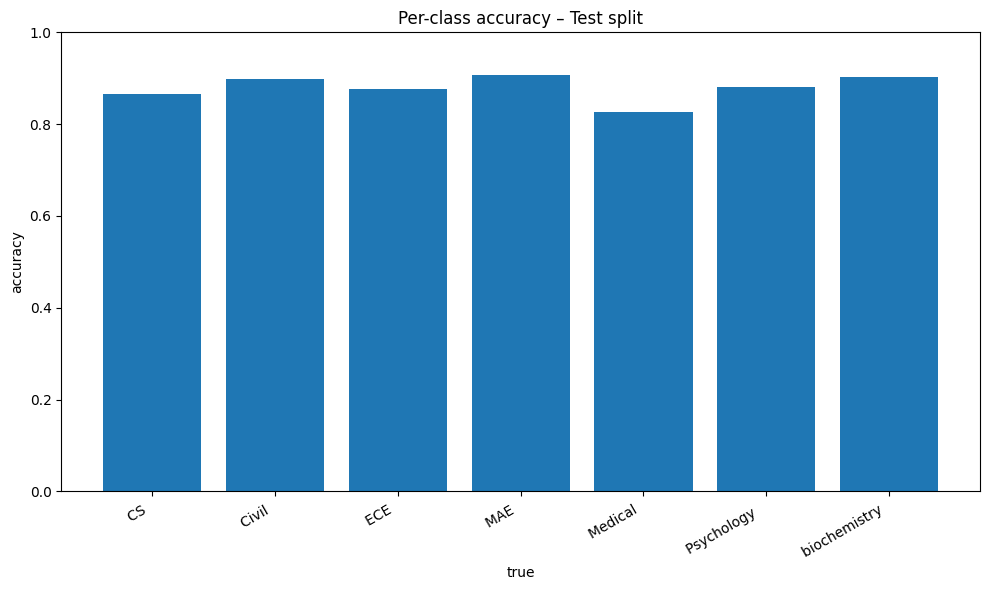

In [5]:
# Compute per-class accuracy = (TP + TN) / total
cm = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(le_dom.classes_)))
N  = cm.sum()
domain_accuracies = []
for i in range(len(le_dom.classes_)):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    tn = N - tp - fn - fp
    domain_accuracies.append((tp + tn) / N)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(le_dom.classes_, domain_accuracies)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.ylabel('accuracy')
plt.xlabel('true')
plt.title('Per-class accuracy – Test split')
plt.tight_layout()
plt.show()

## LDA Visualizer for Domain

In [13]:
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# enable the notebook renderer
pyLDAvis.enable_notebook()

# prepare the visualization data
vis = pyLDAvis.gensim_models.prepare(lda, corpus_train, dictionary)

vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.198571 -0.073204       1        1  25.253541
2      0.226878  0.062598       2        1  17.925443
0     -0.028938 -0.087682       3        1  15.753432
4     -0.065196  0.146863       4        1  14.898135
3     -0.029500  0.173013       5        1  13.707089
6     -0.051587 -0.216331       6        1   6.707430
5     -0.250227 -0.005258       7        1   5.754931, topic_info=            Term          Freq         Total Category  logprob  loglift
225     patients  19593.000000  19593.000000  Default  30.0000  30.0000
2648       water   4515.000000   4515.000000  Default  29.0000  29.0000
67         cells   6543.000000   6543.000000  Default  28.0000  28.0000
1821      levels   6667.000000   6667.000000  Default  27.0000  27.0000
527   expression   6246.000000   6246.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
205       higher    922.362010   5844.271962   Topic7  -5.5449   1.0088
611    treatment    902.005761   9277.586917   Topic7  -5.5672   0.5244
2302      effect    845.026435   5332.525731   Topic7  -5.6324   1.0129
43       results    852.586376  19111.884951   Topic7  -5.6235  -0.2547
182   associated    831.981491   8792.715910   Topic7  -5.6480   0.4972

[556 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2126      5  0.999629   abuse
2800      1  0.041596  access
2800      2  0.889838  access
2800      4  0.010603  access
2800      5  0.057909  access
...     ...       ...     ...
3788      3  0.018432   young
3788      4  0.043776   young
3788      5  0.888576   young
3788      7  0.041472   young
813       5  0.998796   youth

[1279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4, 7, 6])

## Manual Inspection

In [6]:
# inspect individual test abstracts

# Build a results DataFrame
results_df = test_df.copy()
results_df['true_domain'] = le_dom.inverse_transform(y_test)
results_df['pred_domain'] = le_dom.inverse_transform(y_test_pred)
results_df['correct']     = results_df['true_domain'] == results_df['pred_domain']

# Grab one correct example
correct_example = results_df[results_df['correct']].iloc[0]
print("=== Correctly Classified Example ===")
print(f"True domain:      {correct_example['true_domain']}")
print(f"Predicted domain: {correct_example['pred_domain']}")
print("Abstract:")
print(correct_example['Abstract'])
print("\n" + "-"*80 + "\n")

# Grab one incorrect example
incorrect_example = results_df[~results_df['correct']].iloc[0]
print("=== Misclassified Example ===")
print(f"True domain:      {incorrect_example['true_domain']}")
print(f"Predicted domain: {incorrect_example['pred_domain']}")
print("Abstract:")
print(incorrect_example['Abstract'])



=== Correctly Classified Example ===
True domain:      biochemistry 
Predicted domain: biochemistry 
Abstract:
The aim of regenerative engineering is to restore complex tissues and biological systems through convergence in the fields of advanced biomaterials, stem cell science, and developmental biology. Hydrogels are one of the most attractive biomaterials for regenerative engineering, since they can be engineered into tissue mimetic 3D scaffolds to support cell growth due to their similarity to native extracellular matrix. Advanced nano- and micro-technologies have dramatically increased the ability to control properties and functionalities of hydrogel materials by facilitating biomimetic fabrication of more sophisticated compositions and architectures, thus extending our understanding of cell-matrix interactions at the nanoscale. With this perspective, this review discusses the most commonly used hydrogel materials and their fabrication strategies for regenerative engineering. We hi